# Segmentation d'image par architecture U-net

In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Format des données

Les images sont toutes de 64x64 pixels, elles ont donc été redimensionnées pour faire la même taille.

D'autre part on constate qu'on a 3 canaux pour l'entrée, un seul en sortie.  
Ceci nous indique que les images initiales sont en couleur tandis que la sortie est constitué d'un canal binaire  
_(donc seulement le mask qui correspond à la classe de l'objet, on n'utilise pas le contour et le background?)._

Enfin on a 738 images au total (~1/10 du dataset initial). On les sépare en 590 exemples d'entrainemene et 148 de test (soit un partitionnement de 80% / 20%).



In [6]:
X = np.load("data64_red.npy")
Y = np.load("mask64_red.npy")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X shape:", X.shape,
      "\nY shape:", Y.shape,
      "\nX_train shape:", X_train.shape,
      "\nY_train shape:", Y_train.shape,
      "\nX_test shape:", X_test.shape,
      "\nY_test shape:", Y_test.shape)


X shape: (738, 64, 64, 3) 
Y shape: (738, 64, 64, 1) 
X_train shape: (590, 64, 64, 3) 
Y_train shape: (590, 64, 64, 1) 
X_test shape: (148, 64, 64, 3) 
Y_test shape: (148, 64, 64, 1)


### Réseau U-net simpliste

Comme on veut une profondeur de 128 au bottleneck, on utilise une conv2D de 128 à ce stade. La couche précédente et suivante doit être de même taille car on veut une symétrie entre la partie descendante et ascendante pour petmettre la concaténation, ici 64.

Puisque l'on travail avec une classe binaire, on utilise une fonction d'activation final en sigmoid (résultat entre 0 et 1). Pour la même raison, on choisit binary_crossentropy pour la fonction loss

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2 (Conv2D)         │ (None, 64, 64,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p2 (MaxPooling2D)   │ (None, 32, 32,    │          0 │ c2[0][0]          │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c1 (Conv2D)         │ (None, 32, 32,    │     18,496 │ p2[0][0]          │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ c1[0][0]          │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p1 (MaxPooling2D)   │ (None, 16, 16,    │          0 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b (Conv2D)          │ (None, 16, 16,    │     73,856 │ p1[0][0]          │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ b[0][0]           │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u1 (UpSampling2D)   │ (None, 32, 32,    │          0 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u1b (Concatenate)   │ (None, 32, 32,    │          0 │ u1[0][0],         │
│                     │ 192)              │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cd1 (Conv2D)        │ (None, 32, 32,    │    110,656 │ u1b[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u2 (UpSampling2D)   │ (None, 64, 64,    │          0 │ cd1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u2b (Concatenate)   │ (None, 64, 64,    │          0 │ u2[0][0],         │
│                     │ 96)               │            │ c2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cd2 (Conv2D)        │ (None, 64, 64,    │     27,680 │ u2b[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Conv2D)    │ (None, 64, 64, 1) │         33 │ cd2[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,617 (904.75 KB)

 Trainable params: 231,617 (904.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/256
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6671 - dice_coef: 0.5570 - loss: 1.0562 - val_accuracy: 0.7390 - val_dice_coef: 0.5990 - val_loss: 0.9440 - learning_rate: 0.0010
Epoch 2/256
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7403 - dice_coef: 0.6174 - loss: 0.9357 - val_accuracy: 0.7606 - val_dice_coef: 0.6166 - val_loss: 0.8862 - learning_rate: 0.0010
Epoch 3/256
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7588 - dice_coef: 0.6440 - loss: 0.8757 - val_accuracy: 0.7562 - val_dice_coef: 0.5690 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 4/256
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7660 - dice_coef: 0.6502 - loss: 0.8588 - val_accuracy: 0.7703 - val_dice_coef: 0.6247 - val_loss: 0.8774 - learning_rate: 0.0010
Epoch 5/256
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7639 - dice_coef: 0.6464 - loss: 0.8651 - val_accuracy: 0.7947 - val_dice_coef: 0.6717 - val_loss: 0.7901 - learning_rate: 0.0010
Epoch 6/256
74/74 ━━

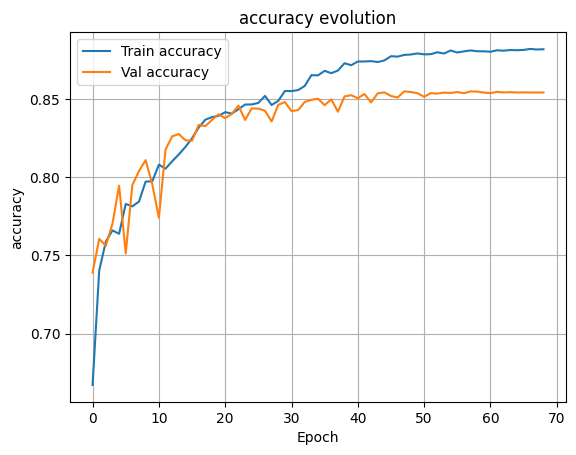

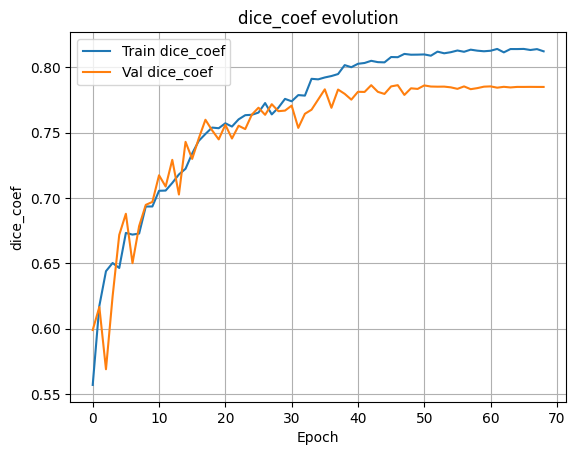

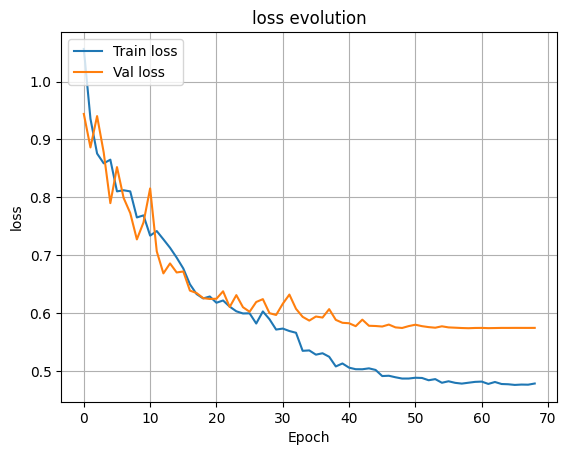

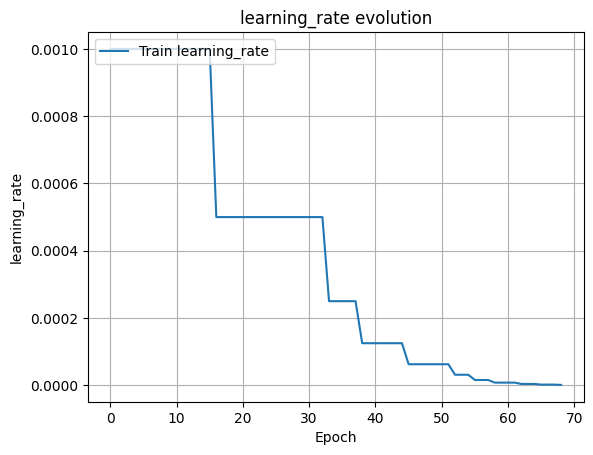

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


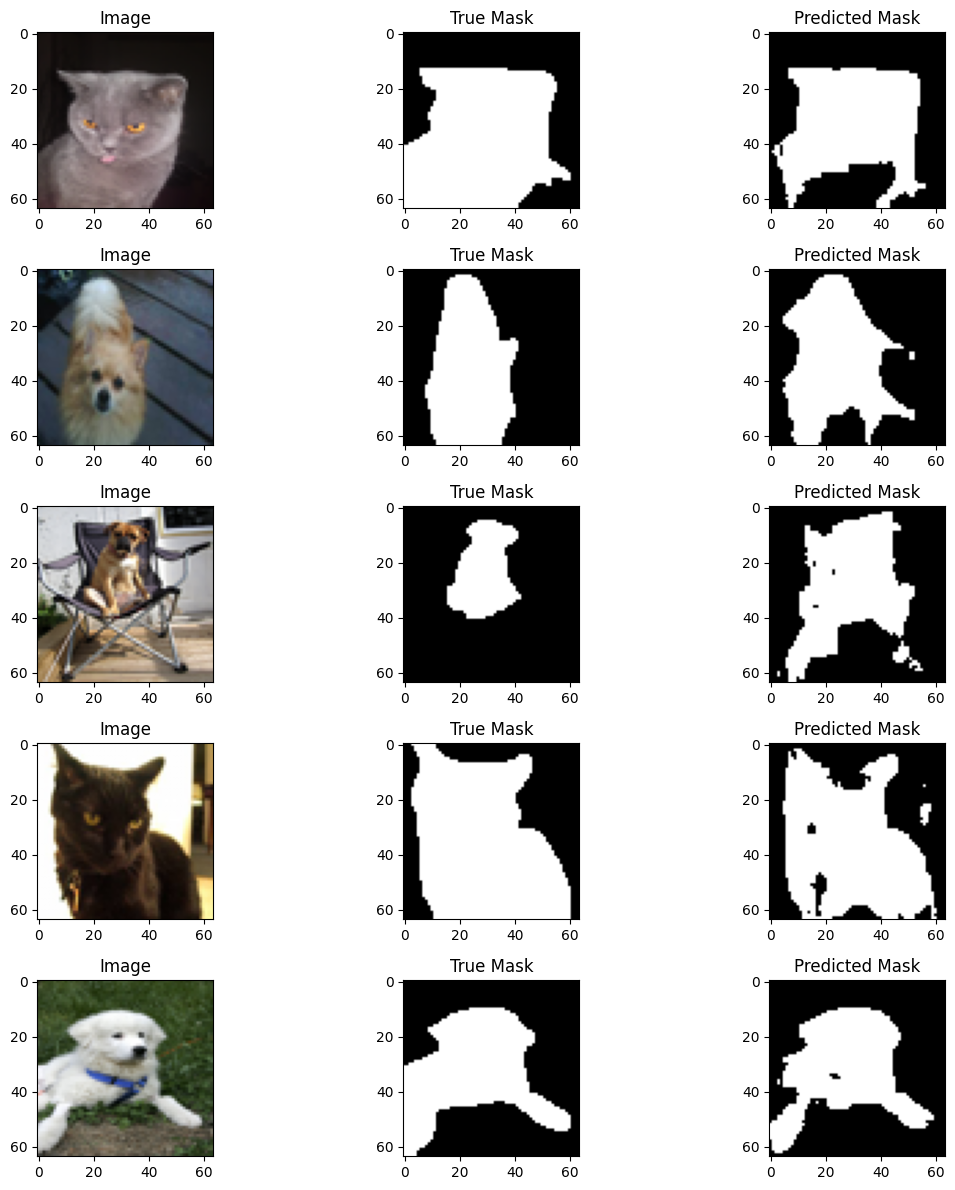

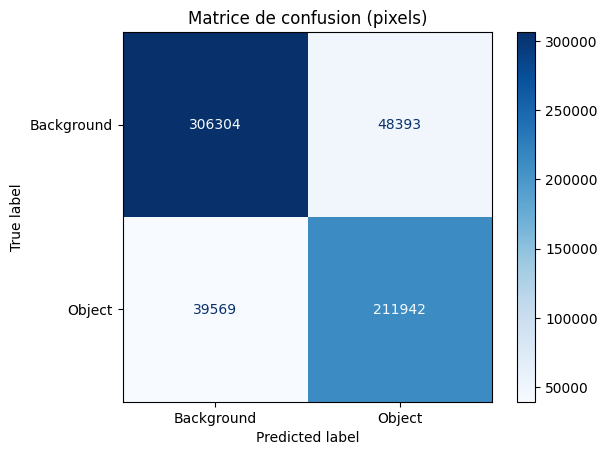


Classification report (par pixel):
              precision    recall  f1-score   support

  Background       0.89      0.86      0.87    354697
      Object       0.81      0.84      0.83    251511

    accuracy                           0.85    606208
   macro avg       0.85      0.85      0.85    606208
weighted avg       0.86      0.85      0.86    606208

Temps d'entraînement : 326.99 secondes


In [ ]:
from TP4_utils import unet_simple, affiche, display_results, eval_classif
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy()
dice = losses.Dice()
alpha = 0.5  # à optimiser éventuellement
def bce_dice_loss(y_true, y_pred):
    return alpha * bce(y_true, y_pred) + (1 - alpha) * dice(y_true, y_pred)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
earlStop = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, restore_best_weights=True, verbose = 1, mode="min")

# Parameters
lr = 1e-3 # base learning rate
model = unet_simple(X_train.shape[1:])
model.summary()
epochs = 256 # max epochs
batch_size = 8

ad = Adam(learning_rate=lr)
model.compile(
    optimizer=ad, 
    loss=bce_dice_loss,
    metrics=["accuracy", dice_coef]
    )

# Entraîner le modèle
tps1 = time.time()
history = model.fit(
    X_train, 
    Y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[earlStop, lr_scheduler],
    validation_data=(X_test, Y_test))
tps2 = time.time()

affiche(history)
preds = model.predict(X_test)
display_results(X_test, Y_test, preds)
eval_classif(Y_test, preds)
print("Temps d'entraînement : {:.2f} secondes".format(tps2 - tps1))


### Apprentissage

| itération | fct perte | profondeur | epoch | temps (s) | nb params | accuracy | callbacks | dropout |
| :--: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| 1 | `bce` | 1 | 10 | 58.84 | 145,473 | **75.66%** | None |  |
| 2 | `bce` | 2 | 10 | 35.56 | 226,593 | **80.15%** | None |  |
| 3 | `bce` | 3 | 10 | 20.02 | 237,457 | **82.10%** | None |  |
| 4 | `bce` | 4 | 10 | 13.54 | 240,073 | **82.37%** | None |  |
| 5 | `bce` | 3 | 23(sur 33) | 60.68 | 237,457 | **85.19%** | [early stopping] |  |
| 6 | `bce` | 3 | 21(sur 31) | 61.12 | 237,457 | **85.95%** | [early stopping, lr scheduler] |  |
| 7 | `bce` | 3 | 26(sur 36) | 67.58 | 237,457 | **86.55%** | [early stopping, lr scheduler] | bottleneck |
| 8 | `bce` | 3 | 32(sur 42) | 83.64 | 237,457 | **87.07%** | [early stopping, lr scheduler] | bottleneck et encodeur |
| 8 | `bce` | 3 | 32(sur 42) | 83.64 | 237,457 | **87.07%** | [early stopping, lr scheduler] | bottleneck, encodeur et décodeur |


lr: 1e-4
optimizer: Adam
batch_size: 8

#### 1 - profondeur de la structure

On commence par s'interesser au nombre de niveau de la structure. À chaque niveau de plus, on ajoute un couple maxpooling / Conv2DTranspose dans l'encodeur et décodeur. On conserve donc un facteur 2 pour les filtre entre chaque niveau. Cela donne par exemple pour 4 niveaux: 16 - 32 - 64 - 128(bottleneck)

| itération | fct perte | profondeur | epoch | temps (s) | nb params | accuracy |
| :--: | :---: | :---: | :---: | :---: | :---: | :---: |
| 1 | `bce` | 1 | 10 | 58.84 | 145,473 | **75.66%** |
| 2 | `bce` | 2 | 10 | 35.56 | 226,593 | **80.15%** |
| 3 | `bce` | 3 | 10 | 20.02 | 237,457 | **82.10%** |
| 4 | `bce` | 4 | 10 | 13.54 | 240,073 | **82.37%** |

À partir de 3 niveau, on constate des signes d'overfitting, de sorte que l'ajout d'un quatrième n'améliore plus significativement la précision. On gardera donc 3 niveau par la suite, et pour réduire l'overfitting un dropout de 0.5 au bottleneck (le plus enclin à surapprendre).

#### 2 - Couches de convolutions par niveau d'encodeur/décodeur

| itération | fct perte | nb couches | epoch | temps (s) | nb params | accuracy |
| :--: | :---: | :---: | :---: | :---: | :---: | :---: |
| 0 | `bce` | 1 | 10 | 20.02 | 237,457 | **82.10%** |
| 1 | `bce` | 2 | 10 | xx.xx | xxx,xxx | **xx.xx%** |
| 2 | `bce` | 3 | 10 | xx.xx | xxx,xxx | **xx.xx%** |

La précision s'améliore jusqu'à N couche, puis _le temps d'entrainement s'allonge, ou overfitting, ou pas de progression significative..._
Par la suite on gardera donc N couches de convolution par niveaux.

#### 3 - UpSampling2D ou Conv2DTranspose

| itération | fct perte | fct | epoch | temps (s) | nb params | accuracy |
| :--: | :---: | :---: | :---: | :---: | :---: | :---: |
| 0 | `bce` | Conv2DTranspose | 10 | xx.xx | xxx,xxx | **xx.xx%** |
| 1 | `bce` | UpSampling2D | 10 | xx.xx | xxx,xxx | **xx.xx%** |

_UpSampling2D devrait améliorer le résultat, car réduit le nombre de paramètres de décodage, qui sont d'importance moindre dans cette structure relativement petite_

#### 4 - Nombre de filtre au bottleneck

On ajustera le nombre de filtres à l'encodeur et au décodeur en fonction.

| itération | fct perte | nb filtres | epoch | temps (s) | nb params | accuracy |
| :--: | :---: | :---: | :---: | :---: | :---: | :---: |
| 0 | `bce` | 128 | 10 | xx.xx | xxx,xxx | **xx.xx%** |
| 1 | `bce` | 64 | 10 | xx.xx | xxx,xxx | **xx.xx%** |
| 2 | `bce` | 256 | 10 | xx.xx | xxx,xxx | **xx.xx%** |

_On constate (probablement) que 64 est trop peu, mais 256 est trop_

#### 5 - fonction perte

| itération | fct perte | epoch | temps (s) | nb params | accuracy |
| :--: | :---: | :---: | :---: | :---: | :---: |
| 0 | `bce` | 10 | xx.xx | xxx,xxx | **xx.xx%** |
| 1 | `dice` | 10 | xx.xx | xxx,xxx | **xx.xx%** |
| 1 | `bce + dice` | 10 | xx.xx | xxx,xxx | **xx.xx%** |



In [8]:

model.compile(
    optimizer="adam",
    loss={
        "output1": "binary_crossentropy",
        "output2": "binary_crossentropy",
        "output3": "binary_crossentropy"
    },
    loss_weights={
        "output1": 1,
        "output2": 1,
        "output3":1
    },
    metrics={
        "output1": ["accuracy"],
        "output2": ["accuracy"],
        "output3": ["accuracy"]
    }
)

